In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
# Configure warnings to always be triggered
warnings.simplefilter("always")


def get_matrix_value(matrix, x, y):
    # Convert normalized coordinates to matrix indices
    ix = np.int32(x * (matrix.shape[0] - 1))
    iy =  np.int32(y * (matrix.shape[1] - 1))
    
    # Access and return the value at the specified index
    return matrix[ix, iy]

def Gaussian_Estimation(x, y, prediction_range,  optimizer, noise_level, length_scale, sigma_f):

    # Define the kernel
    noise_level = noise_level
    length_scale = length_scale
    sigma_f = sigma_f * sigma_f
    # kernel = C(sigma_f) * RBF(length_scale,(0.1, 0.3)) 
    kernel = C(sigma_f, (1e-3, 1e3)) * RBF(length_scale, (1e-2, 1e2)) + WhiteKernel(noise_level, (0, 0.2))

    # Instantiate the Gaussian Process Regressor
    if(not optimizer):
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, random_state=0, optimizer=None)
    else:
        gp = GaussianProcessRegressor(kernel=kernel)
    # x = np.array([x])
    # x = x.T
    # Fit the model to the data
    gp.fit(x, y)

    # Make predictions on new data points
    X_new = prediction_range
    
    y_pred, y_std = gp.predict(X_new, return_std=True)
    
    #calculate discrepancy
    
    information = np.exp(-np.square(y_std))
    # noise_level_optimized = gp.kernel_.get_params()["k2__noise_level"]
   
    return y_pred, information, y_std, #noise_level_optimized

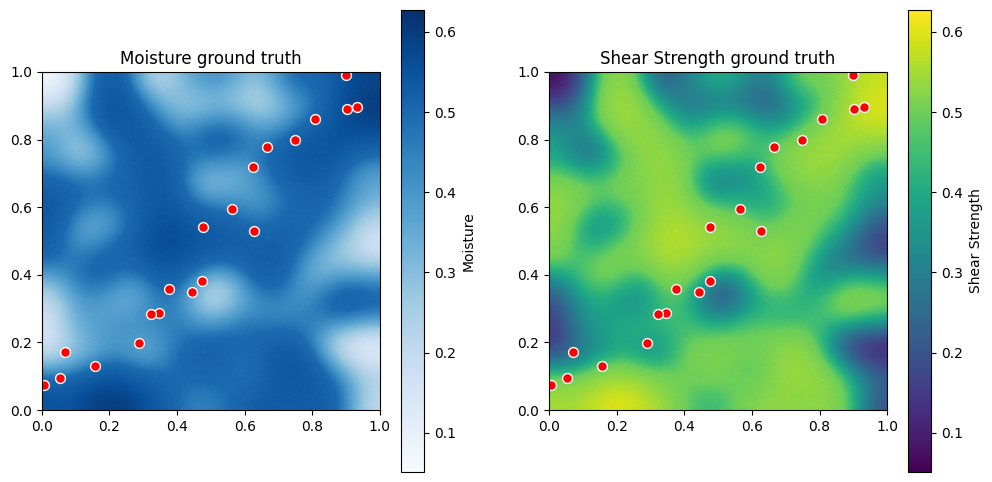

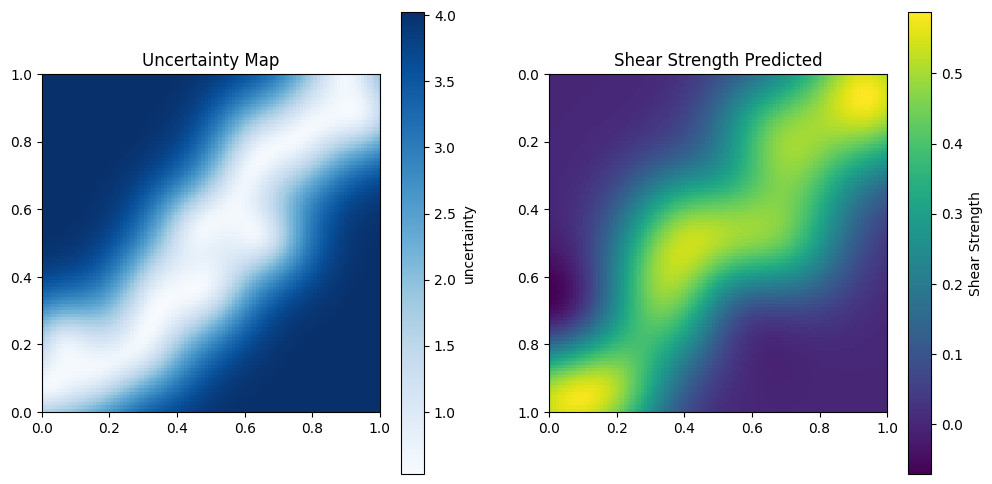

In [33]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
# Read the CSV file back into a NumPy array
shear_strength_map = np.loadtxt('shear_strength_map.csv', delimiter=',')
moisture_map = np.loadtxt('moisture_map.csv', delimiter=',')
# choose a random path
# we assume x, y coordinates are limited to [0,1], [0,1]
# we are going to use gaussian process to estimate the data given the current robot path
# assume the robot start at coordinates [0, 1]
# assume the robot have a certain sampling density 
# the current dataset interval is 0.001, so the robot sampling interval should be larger than 0.001
# in real sceanrio, it can be an analog value
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

Information_image = ax[0].imshow(moisture_map, cmap='Blues', extent=[0, 1, 0, 1], origin='lower')
ax[0].set_title('Moisture ground truth')
cb_info = fig.colorbar(Information_image, ax=ax[0], label='Moisture')

shear_strength_image = ax[1].imshow(shear_strength_map, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
ax[1].set_title('Shear Strength ground truth')
cb_strength = fig.colorbar(shear_strength_image, ax=ax[1], label='Shear Strength')




#let's do a quick example
#assume the robot samples on a straight line(some points)
# Generate points on the line from (0, 0) to (1, 1)
points = np.linspace(0, 1, 20)
noise = np.random.normal(0, 0.05, (20, 2))
noisy_points = np.vstack((points, points)).T + noise
noisy_points[:, 0] = np.clip(noisy_points[:, 0], 0, 0.99)
noisy_points[:, 1] = np.clip(noisy_points[:, 1], 0, 0.99)
indices = (noisy_points * np.array([shear_strength_map.shape[0], shear_strength_map.shape[1]])).astype(int)

# Retrieve values from the array
data_points = [shear_strength_map[i, j] for i, j in indices]
ax[1].scatter(noisy_points[:, 1], noisy_points[:, 0], color='red', s=50, edgecolor='white', label='Points')
ax[0].scatter(noisy_points[:, 1], noisy_points[:, 0], color='red', s=50, edgecolor='white', label='Points')
plt.show()
 


 # using gaussian process to predict
estimatedNum = 100
xx1, xx2 = np.linspace(0, 1, num=estimatedNum), np.linspace(0, 1, num=estimatedNum)
vals = np.array([[x1_, x2_] for x1_ in xx1 for x2_ in xx2])
measured_shear = get_matrix_value(shear_strength_map, noisy_points[:, 0], noisy_points[:, 1])
measured_moisture = get_matrix_value(moisture_map, noisy_points[:, 0], noisy_points[:, 1])
robot_measured_points = np.array([noisy_points[:, 0], noisy_points[:, 1]]).T
shear_prediction, information_shear, shear_std = Gaussian_Estimation(robot_measured_points,  measured_shear,   vals, False, noise_level=0.2, length_scale=0.15, sigma_f=4)


shear_prediction = shear_prediction.reshape(estimatedNum, estimatedNum)
information_shear = information_shear.reshape(estimatedNum, estimatedNum)
shear_std = shear_std.reshape(estimatedNum, estimatedNum)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
Information_image = ax[0].imshow(shear_std, cmap='Blues',extent=[0, 1, 0, 1], origin='lower')
ax[0].set_title('Uncertainty Map')
cb_uncertainty = fig.colorbar(Information_image, ax=ax[0], label='uncertainty')
shear_strength_image = ax[1].imshow(shear_prediction, cmap='viridis', extent=[0, 1, 1, 0], origin='lower')
cb_strength = fig.colorbar(shear_strength_image, ax=ax[1], label='Shear Strength')
ax[1].set_title('Shear Strength Predicted')
plt.show()
